In [1]:
# ─── REPRODUCIBILITY SEED ──────────────────────────────────────────────────────
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # ensure deterministic convs on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import joblib


# ─── 0) REPRODUCIBILITY ───────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# (If you use PyTorch/CUDA elsewhere, seed torch too)

# ─── 1) CONFIG ─────────────────────────────────────────────────────────────────
TICKERS    = ["AAPL","JPM","AMZN","TSLA","MSFT"]
SEQ_LEN    = 60
INITIAL_BALANCE = 10_000

# ─── 2) CUSTOM ENV ─────────────────────────────────────────────────────────────
class RLTradingEnvWithLSTM(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, df, state_matrix, initial_balance=INITIAL_BALANCE):
        super().__init__()
        self.df           = df.reset_index(drop=True)
        self.state_matrix = state_matrix
        self.initial_balance = initial_balance

        # actions: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)
        # observation: [state_feats…, price, cash, shares]
        obs_dim = state_matrix.shape[1] + 3
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.balance      = self.initial_balance
        self.shares       = 0
        self.net_worth    = self.initial_balance
        self.current_step = 0
        return self._get_observation()

    def _get_observation(self):
        # clamp step so we don't run off the end
        if self.current_step + SEQ_LEN >= len(self.df):
            self.current_step = len(self.df) - SEQ_LEN - 1

        # pick the LSTM features row
        idx = min(self.current_step, len(self.state_matrix)-1)
        feats = self.state_matrix[idx]

        price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
        return np.array(
            np.append(feats, [price, self.balance, self.shares]),
            dtype=np.float32
        )

    def step(self, action):
        self.current_step += 1
        price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
        prev_value = self.net_worth

        # execute action
        if action == 1 and self.balance >= price:
            n = self.balance // price
            self.balance -= n * price
            self.shares  += n
        elif action == 2 and self.shares > 0:
            self.balance += self.shares * price
            self.shares   = 0

        # update net worth & reward
        self.net_worth = self.balance + self.shares * price
        reward = np.clip(self.net_worth - prev_value, -100, 100)

        done = (self.current_step + SEQ_LEN) >= (len(self.df)-1)
        obs  = self._get_observation()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step {self.current_step} — Net Worth: £{self.net_worth:.2f}")

# ─── 3) ENV FACTORY ─────────────────────────────────────────────────────────────
def make_env(ticker):
    def _init():
        df = (
            yf.download(ticker, start="2023-01-01", end="2025-01-01",
                        auto_adjust=True, progress=False)
              .reset_index()[['Date','Close']]
        )
        state = np.load(f"processed_data/{ticker.lower()}_state_cnnlstm_test.npy")
        env = RLTradingEnvWithLSTM(df, state, initial_balance=INITIAL_BALANCE)
        env.seed(SEED)
        env.action_space.seed(SEED)
        env.observation_space.seed(SEED)
        return env
    return _init

# ─── 4) VECTORISED ENV & TRAINING ──────────────────────────────────────────────
env_fns = [make_env(t) for t in TICKERS]
vec_env = DummyVecEnv(env_fns)
vec_env.seed(SEED)

model = PPO(
    "MlpPolicy",
    vec_env,
    seed=SEED,
    verbose=1
)
model.learn(total_timesteps=200_000)
model.save("cnn_lstm_multi_stock_ppo.zip")
joblib.dump(model, 'models/rl_agent.pkl')


print("✅ Trained PPO agent across multiple stocks.")


e:\Dissertation\stock_exchange_bot\stockbot\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
e:\Dissertation\stock_exchange_bot\stockbot\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
e:\Dissertation\stock_exchange_bot\stockbot\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatic

Using cpu device


C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


------------------------------
| time/              |       |
|    fps             | 785   |
|    iterations      | 1     |
|    time_elapsed    | 13    |
|    total_timesteps | 10240 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 617         |
|    iterations           | 2           |
|    time_elapsed         | 33          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.003987976 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 2.25e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.4e+04     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000838   |
|    value_loss           | 3.13e+04    |
-----------------------------------------
---------------------------

C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


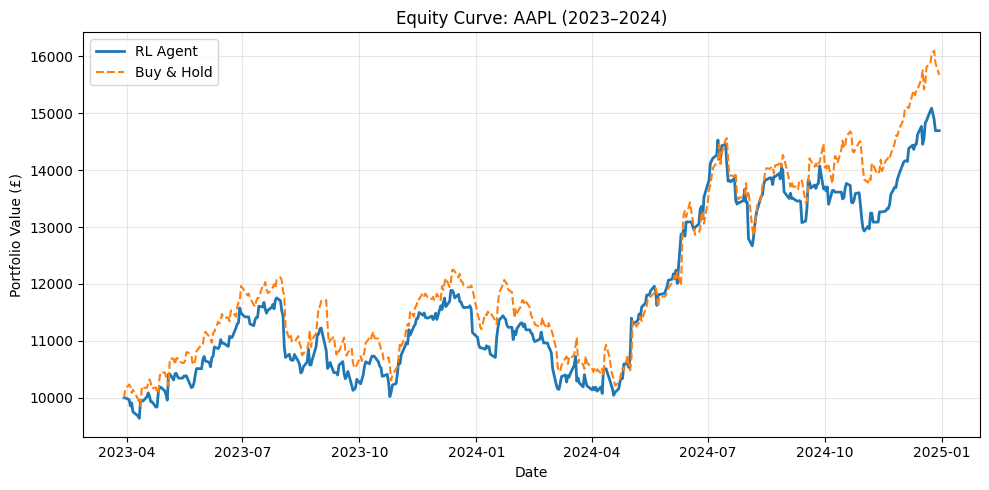

AAPL: Return 46.93% | Sharpe 1.20 | Max DD -15.50% | Buys/Sells 259/39



C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


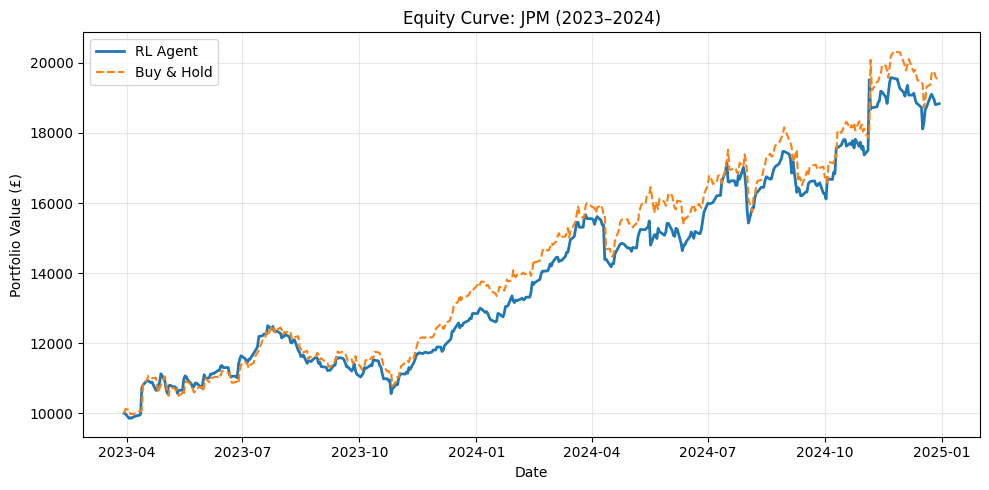

JPM: Return 88.37% | Sharpe 1.86 | Max DD -15.50% | Buys/Sells 251/50



C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


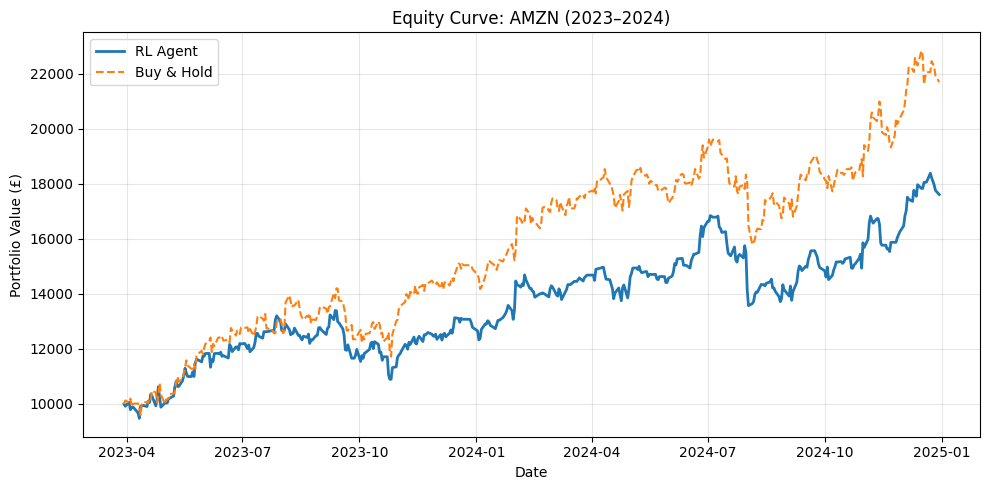

AMZN: Return 76.10% | Sharpe 1.35 | Max DD -19.44% | Buys/Sells 226/44



C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


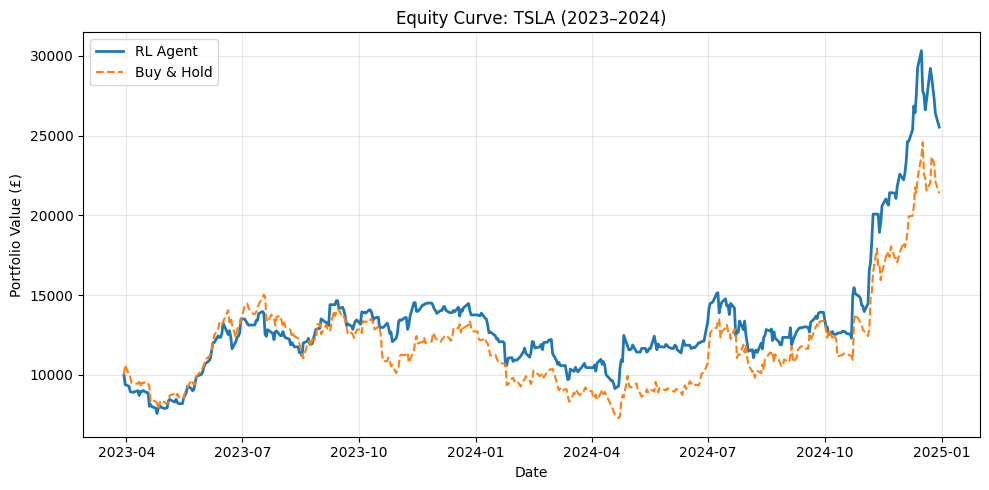

TSLA: Return 155.25% | Sharpe 1.27 | Max DD -37.60% | Buys/Sells 258/46



C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_28428\1706716186.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.df.loc[self.current_step + SEQ_LEN, 'Close'])


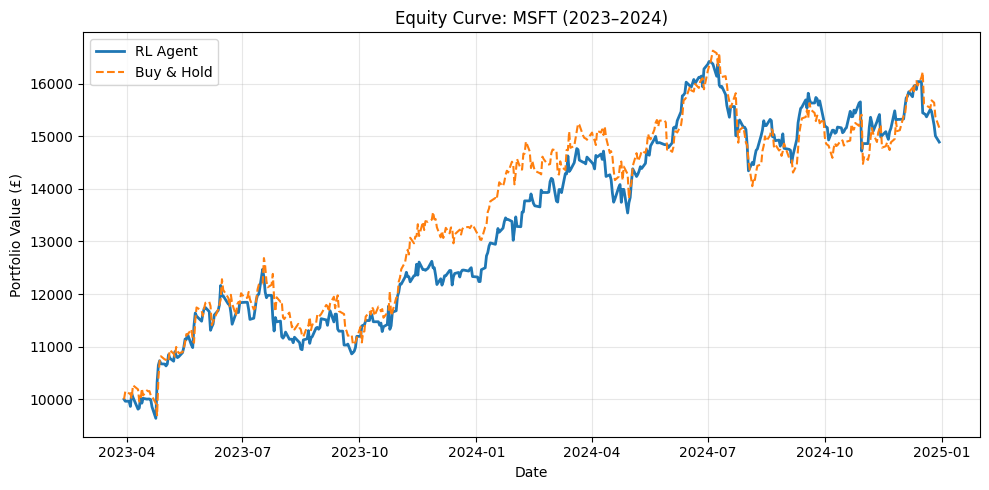

MSFT: Return 48.89% | Sharpe 1.24 | Max DD -12.90% | Buys/Sells 234/40



In [3]:
import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import Counter
from stable_baselines3 import PPO
import gym
from gym import spaces
from gym.utils import seeding

# ─── 0) CONSTANTS & SEED ───────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TICKERS         = ["AAPL","JPM","AMZN","TSLA","MSFT"]
SEQ_LEN         = 60
INITIAL_BALANCE = 10_000

# ─── 1) ENV DEFINITION ─────────────────────────────────────────────────────────

# ─── 2) LOAD PPO AGENT ─────────────────────────────────────────────────────────
model = PPO.load("cnn_lstm_multi_stock_ppo.zip")

# ─── 3) BACKTEST FUNCTION ─────────────────────────────────────────────────────
def backtest(signal, prices, cash0=INITIAL_BALANCE):
    cash, shares = cash0, 0
    eq_curve     = []
    for i, p in enumerate(prices):
        if signal[i] == 1 and shares == 0:
            shares = cash / p; cash = 0
        elif signal[i] == 0 and shares > 0:
            cash = shares * p; shares = 0
        eq_curve.append(cash + shares * p)
    return np.array(eq_curve)

# ─── 4) EVALUATE & PLOT ────────────────────────────────────────────────────────
for ticker in TICKERS:
    # a) load full price series
    df = (
        yf.download(ticker,
                    start="2023-01-01", end="2025-01-01",
                    auto_adjust=True, progress=False)
          .reset_index()[["Date","Close"]]
    )
    dates = df["Date"].to_numpy()
    prices= df["Close"].to_numpy()

    # b) load LSTM state matrix
    state_matrix = np.load(f"processed_data/{ticker.lower()}_state_cnnlstm_test.npy")

    # c) create and seed env
    env = RLTradingEnvWithLSTM(df, state_matrix)
    env.seed(SEED)
    env.action_space.seed(SEED)
    env.observation_space.seed(SEED)

    # d) run the RL agent
    obs = env.reset()
    done = False
    net_worths = []
    actions    = []
    while not done:
        action, _ = model.predict(obs, deterministic=False)
        obs, _, done, _ = env.step(action)
        net_worths.append(env.net_worth)
        actions.append(int(action))

    # e) align RL curve to dates/prices
    start = SEQ_LEN
    end   = SEQ_LEN + len(net_worths)
    dates_rl  = dates[start:end]
    prices_rl = prices[start:end]

    # f) compute buy & hold baseline
    bh_curve = backtest(np.ones(len(prices_rl),dtype=int), prices_rl)

    # g) plot equity curves
    plt.figure(figsize=(10,5))
    plt.plot(dates_rl, net_worths, label="RL Agent",    linewidth=2)
    plt.plot(dates_rl, bh_curve,    label="Buy & Hold",  linestyle="--")
    plt.title(f"Equity Curve: {ticker} (2023–2024)")
    plt.xlabel("Date"); plt.ylabel("Portfolio Value (£)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

    # h) summary metrics
    rets      = np.diff(net_worths) / net_worths[:-1]
    total_ret = (net_worths[-1] - net_worths[0]) / net_worths[0] * 100
    sharpe    = (rets.mean() / rets.std() * np.sqrt(252)) if rets.std() else 0
    mdd       = ((net_worths - np.maximum.accumulate(net_worths)) / np.maximum.accumulate(net_worths)).min() * 100
    buys      = actions.count(1)
    sells     = actions.count(2)

    print(f"{ticker}: Return {total_ret:.2f}% | Sharpe {sharpe:.2f} | Max DD {mdd:.2f}% | Buys/Sells {buys}/{sells}\n")
